In [1]:
import pandas as pd 
import numpy as np
import joblib
import time
import sklearn.metrics
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

## Dataset Prepare

In [6]:
def calculate_macro_tpr_fpr(voting_cm):
    num_classes = voting_cm.shape[0]
    tpr_list = []
    fpr_list = []

    for i in range(num_classes):
        TP = voting_cm[i, i]
        FN = np.sum(voting_cm[i, :]) - TP
        FP = np.sum(voting_cm[:, i]) - TP
        TN = np.sum(voting_cm) - (TP + FN + FP)

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        tpr_list.append(TPR)
        fpr_list.append(FPR)

    macro_tpr = np.mean(tpr_list)
    macro_fpr = np.mean(fpr_list)

    return macro_tpr, macro_fpr

### Merge CovaS generated Dataset and LLM Generated Dataset

In [ ]:
import pandas as pd

covas_train_file = "./DS/train_shap_52.csv"
llm_generated_train_file = "./DS/llm_generated_ds.csv"

covas_train = pd.read_csv(covas_train_file)
llm_generated_train = pd.read_csv(llm_generated_train_file)

merged_df = pd.concat([covas_train, llm_generated_train], ignore_index=True)

# merged_df.to_csv("./DS/final_train.csv", index=False)


### Load final Dataset

In [7]:

train = pd.read_csv('./DS/final_train.csv')
test = pd.read_csv('./DS/final_test.csv') # rename test file to final_test.csv

X_train = train.drop(['Label'], axis=1)
y_train = train['Label']
X_test = test.drop(['Label'], axis=1)
y_test = test['Label']

## 2. Base models Evaluation

### XGBoost

In [8]:
xgb_params = {
    'device': 'cuda',
    'max_depth': 128,
    'n_estimators': 5000,
    'objective':"multi:softmax", 
    'num_class':len(y_train.unique())  ,
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'eval_metric': 'auc',
    'verbosity': 0
}


xgb_model = XGBClassifier(**xgb_params)
# xgb_model = joblib.load('./models/augmented_xgb_best.pkl')
xgb_model.fit(X_train,y_train)
joblib.dump(xgb_model, './models/augmented_xgb_best.pkl')
xgb_start_time = time.time()
xgb_prediction = xgb_model.predict(X_test)
xgb_end_time = time.time()
xgb_time = xgb_end_time - xgb_start_time

xgb_acc = sklearn.metrics.accuracy_score(xgb_prediction, y_test)
xgb_precision = sklearn.metrics.precision_score(xgb_prediction, y_test, average='micro')
xgb_f1 = sklearn.metrics.f1_score(xgb_prediction, y_test, average='micro')
xgb_recall = sklearn.metrics.recall_score(xgb_prediction, y_test, average='micro')
xgb_cm = sklearn.metrics.confusion_matrix(xgb_prediction, y_test)
xgb_fp = xgb_cm[0, 1]
xgb_tpr, xgb_fpr = calculate_macro_tpr_fpr(xgb_cm)
print("XGBoost Time:", xgb_time)
print("XGBoost Accuracy:", xgb_acc)
print("XGBoost Precision:", xgb_precision)
print("XGBoost F1:", xgb_f1)
print("XGBoost Recall:", xgb_recall)
print("XGBoost FP", xgb_fp)
print(f'XGBoost Macro-average TPR: {xgb_tpr}')
print(f'XGBoost Macro-average FPR: {xgb_fpr}')
print("XGBoost CM:\n", xgb_cm)

XGBoost Time: 0.045824289321899414
XGBoost Accuracy: 0.866370808678501
XGBoost Precision: 0.866370808678501
XGBoost F1: 0.8663708086785009
XGBoost Recall: 0.866370808678501
XGBoost FP 0
XGBoost Macro-average TPR: 0.8646793575947695
XGBoost Macro-average FPR: 0.012052753901539546
XGBoost CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  35   0  11   0   0]
 [  0   0   0 169   1   0   0   6   0   0   0   0]
 [  0   0   0   0 167   1   1   2   0   0   0   0]
 [  0   0   0   0   0 168   0   1   1   0   0   0]
 [  0   0   0   0   1   0 168   0   0   0   0   0]
 [  0   0   0   0   0   0   0  84  36   5   0   0]
 [  0   0   0   0   0   0   0  18 132   0   0   0]
 [  0   0   0   0   0   0   0   9   0  99  75   0]
 [  0   0   0   0   0   0   0  13   0  54  94   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]


### ExtraTree

In [9]:
et_params = {
    "n_estimators": 507,
    "max_leaf_nodes": 12000,
    "n_jobs": -1,
    "random_state": 42,
    "bootstrap": True,
    "criterion": "entropy"
}

et_model = ExtraTreesClassifier(**et_params)
# et_model = joblib.load('./models/augmented_et_best.pkl')
et_model.fit(X=X_train, y=y_train)
joblib.dump(et_model, './models/augmented_et_test.pkl')
et_start_time = time.time()
et_prediction = et_model.predict(X_test)
et_end_time = time.time()
et_time = et_end_time - et_start_time

et_acc = sklearn.metrics.accuracy_score(et_prediction, y_test)
et_precision = sklearn.metrics.precision_score(et_prediction, y_test, average='micro')
et_f1 = sklearn.metrics.f1_score(et_prediction, y_test, average='micro')
et_recall = sklearn.metrics.recall_score(et_prediction, y_test, average='micro')
et_cm = sklearn.metrics.confusion_matrix(et_prediction, y_test)
et_fp = et_cm[0, 1]
et_tpr, et_fpr = calculate_macro_tpr_fpr(et_cm)
print("ExtraTrees Time:", et_end_time - et_start_time)
print("ExtraTrees Accuracy:", et_acc)
print("ExtraTrees Precision:", et_precision)
print("ExtraTrees F1:", et_f1)
print("ExtraTrees Recall:", et_recall)
print("ExtraTrees FP:", et_fp)
print(f'XGBoost Macro-average TPR: {et_tpr}')
print(f'XGBoost Macro-average FPR: {et_fpr}')
print("ExtraTrees CM:\n", et_cm)

ExtraTrees Time: 0.5484709739685059
ExtraTrees Accuracy: 0.8703155818540433
ExtraTrees Precision: 0.8703155818540433
ExtraTrees F1: 0.8703155818540433
ExtraTrees Recall: 0.8703155818540433
ExtraTrees FP: 0
XGBoost Macro-average TPR: 0.8690774565901175
XGBoost Macro-average FPR: 0.011714324731670464
ExtraTrees CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  22   0   9   0   0]
 [  0   0   0 169   0   0   0   0   0   0   0   0]
 [  0   0   0   0 169   0   0   0   0   0   0   0]
 [  0   0   0   0   0 169   0   0   0   0   0   0]
 [  0   0   0   0   0   0 169   0   0   0   0   0]
 [  0   0   0   0   0   0   0  90  32   6   0   0]
 [  0   0   0   0   0   0   0  34 137   0   0   0]
 [  0   0   0   0   0   0   0   9   0 104  87   0]
 [  0   0   0   0   0   0   0  13   0  50  82   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]


### RandomForest

In [10]:
rf_params = {
    "n_estimators": 700,
    "max_leaf_nodes": 15000,
    "n_jobs": -1,
    "random_state": 0,
    "bootstrap": True,
    "criterion": "entropy"
}

rf_model = RandomForestClassifier(**rf_params)
# rf_model = joblib.load('./models/augmented_rf_best.pkl')
rf_model.fit(X=X_train, y=y_train)
joblib.dump(rf_model, './models/augmented_rf_best.pkl')
rf_start_time = time.time()
rf_prediction = rf_model.predict(X_test)
rf_end_time = time.time()
rf_time = rf_end_time - rf_start_time

rf_acc = sklearn.metrics.accuracy_score(rf_prediction, y_test)
rf_precision = sklearn.metrics.precision_score(rf_prediction, y_test, average='micro')
rf_f1 = sklearn.metrics.f1_score(rf_prediction, y_test, average='micro')
rf_recall = sklearn.metrics.recall_score(rf_prediction, y_test, average='micro')
rf_cm = sklearn.metrics.confusion_matrix(rf_prediction, y_test)
rf_fp = rf_cm[0, 1]
rf_tpr, rf_fpr = calculate_macro_tpr_fpr(rf_cm)
print("RandomForest Time:", rf_end_time - rf_start_time)
print("RandomForest Accuracy:", rf_acc)
print("RandomForest Precision:", rf_precision)
print("RandomForest F1:", rf_f1)
print("RandomForest Recall:", rf_recall)
print("RandomForest FP:", rf_fp)
print(f'RandomForest Macro-average FPR: {rf_fpr}')
print(f'RandomForest Macro-average TPR: {rf_tpr}')
print("RandomForest CM:\n", rf_cm)

RandomForest Time: 0.32867908477783203
RandomForest Accuracy: 0.8717948717948718
RandomForest Precision: 0.8717948717948718
RandomForest F1: 0.8717948717948718
RandomForest Recall: 0.8717948717948718
RandomForest FP: 0
RandomForest Macro-average FPR: 0.011559418553544235
RandomForest Macro-average TPR: 0.8713139698485457
RandomForest CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  28   0  10   0   0]
 [  0   0   0 169   0   0   0   0   0   0   0   0]
 [  0   0   0   0 169   0   0   1   0   0   0   0]
 [  0   0   0   0   0 169   0   0   0   0   0   0]
 [  0   0   0   0   0   0 169   0   0   0   0   0]
 [  0   0   0   0   0   0   0  89  29   5   0   0]
 [  0   0   0   0   0   0   0  29 140   0   0   0]
 [  0   0   0   0   0   0   0  10   0 107  89   0]
 [  0   0   0   0   0   0   0  11   0  47  80   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]


### LSTM

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score


train = pd.read_csv('./DS/final_train.csv')
test = pd.read_csv('./DS/final_test.csv')

In [4]:
class TabularLSTMDataset(Dataset):
    def __init__(self, data, target_col):
        # Separate features and target
        self.X = data.drop(columns=[target_col]).values
        self.y = data[target_col].values
        
        # Scale features
        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(self.X)
        
        # Convert to tensors
        self.X = torch.FloatTensor(self.X)
        self.y = torch.FloatTensor(self.y).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LSTMTabularModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1, dropout=0.3):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_size)
        )
    
    def forward(self, x):
        # Ensure input is 3D for LSTM
        if x.dim() == 2:
            x = x.unsqueeze(1)
        
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        return self.fc(out)

def train_lstm_model(train, test, target_col, task_type='multiclass', epochs=100, learning_rate=0.001):
    # Prepare datasets
    train_dataset = TabularLSTMDataset(train, target_col)
    test_dataset = TabularLSTMDataset(test, target_col)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Model initialization with dynamic input size
    input_size = train_dataset.X.shape[1]
    
    # Determine output size based on task type
    if task_type == 'regression':
        output_size = 1
    else:
        output_size = len(np.unique(train[target_col]))
    
    model = LSTMTabularModel(input_size=input_size, output_size=output_size)
    
    # Loss function based on task type
    if task_type == 'regression':
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.squeeze().long() if task_type != 'regression' else batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_preds = []
        for batch_x, _ in test_loader:
            batch_pred = model(batch_x)
            test_preds.append(batch_pred)
        
        test_preds = torch.cat(test_preds).numpy()
    
    # Compute metrics
    if task_type == 'regression':
        true_labels = test[target_col].values if target_col in test.columns else None
        metrics = {
            'MSE': mean_squared_error(true_labels, test_preds) if true_labels is not None else None,
            'MAE': mean_absolute_error(true_labels, test_preds) if true_labels is not None else None,
            'R2': r2_score(true_labels, test_preds) if true_labels is not None else None
        }
    else:
        le = LabelEncoder()
        true_labels = le.fit_transform(test[target_col]) if target_col in test.columns else None
        
        # Convert predictions to class labels
        pred_labels = np.argmax(test_preds, axis=1)
        
        metrics = {
            'Accuracy': accuracy_score(true_labels, pred_labels) if true_labels is not None else None,
            'F1 Score': f1_score(true_labels, pred_labels, average='weighted') if true_labels is not None else None
        }
    
    # Create a copy of test to avoid modification
    test_with_preds = test.copy()
    test_with_preds['Predictions'] = pred_labels if task_type != 'regression' else test_preds
    
    return model, test_with_preds, metrics

# Example usage
def main():
    target_column = 'Label'
    task_type = 'multiclass'  # or 'binary' or 'regression'
    
    model, test_with_predictions, eval_metrics = train_lstm_model(
        train, test, target_column, task_type=task_type
    )
    
    # Print evaluation metrics
    print("Evaluation Metrics:")
    for metric, value in eval_metrics.items():
        print(f"{metric}: {value}")
    
    # Save predictions
    test_with_predictions.to_csv('./DL-model-preds/lstm_predictions.csv', index=False)

if __name__ == '__main__':
    main()

Epoch [1/100], Loss: 1.2286
Epoch [2/100], Loss: 0.8095
Epoch [3/100], Loss: 0.7476
Epoch [4/100], Loss: 0.7078
Epoch [5/100], Loss: 0.6878
Epoch [6/100], Loss: 0.6754
Epoch [7/100], Loss: 0.6665
Epoch [8/100], Loss: 0.6608
Epoch [9/100], Loss: 0.6563
Epoch [10/100], Loss: 0.6511
Epoch [11/100], Loss: 0.6476
Epoch [12/100], Loss: 0.6430
Epoch [13/100], Loss: 0.6401
Epoch [14/100], Loss: 0.6385
Epoch [15/100], Loss: 0.6332
Epoch [16/100], Loss: 0.6347
Epoch [17/100], Loss: 0.6289
Epoch [18/100], Loss: 0.6306
Epoch [19/100], Loss: 0.6269
Epoch [20/100], Loss: 0.6224
Epoch [21/100], Loss: 0.6221
Epoch [22/100], Loss: 0.6199
Epoch [23/100], Loss: 0.6180
Epoch [24/100], Loss: 0.6184
Epoch [25/100], Loss: 0.6159
Epoch [26/100], Loss: 0.6134
Epoch [27/100], Loss: 0.6124
Epoch [28/100], Loss: 0.6102
Epoch [29/100], Loss: 0.6083
Epoch [30/100], Loss: 0.6069
Epoch [31/100], Loss: 0.6083
Epoch [32/100], Loss: 0.6085
Epoch [33/100], Loss: 0.6031
Epoch [34/100], Loss: 0.6032
Epoch [35/100], Loss: 0

### DNN

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score

class TabularDataset(Dataset):
    def __init__(self, data, target_col):
        # Separate features and target
        self.X = data.drop(columns=[target_col]).values
        self.y = data[target_col].values
        
        # Scale features
        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(self.X)
        
        # Convert to tensors
        self.X = torch.FloatTensor(self.X)
        self.y = torch.FloatTensor(self.y).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers=[128, 64, 32], output_size=1, dropout=0.3):
        super().__init__()
        
        layers = []
        prev_size = input_size
        
        # Hidden layers
        for hidden_size in hidden_layers:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, output_size))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

def train_dnn_model(train, test, target_col, task_type='multiclass', epochs=100, learning_rate=0.001):
    # Prepare datasets
    train_dataset = TabularDataset(train, target_col)
    test_dataset = TabularDataset(test, target_col)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Model initialization with dynamic input size
    input_size = train_dataset.X.shape[1]
    
    # Determine output size based on task type
    if task_type == 'regression':
        output_size = 1
    else:
        output_size = len(np.unique(train[target_col]))
    
    model = DeepNeuralNetwork(input_size=input_size, output_size=output_size)
    
    # Loss function based on task type
    if task_type == 'regression':
        criterion = nn.MSELoss()
    else:
        criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.squeeze().long() if task_type != 'regression' else batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_preds = []
        for batch_x, _ in test_loader:
            batch_pred = model(batch_x)
            test_preds.append(batch_pred)
        
        test_preds = torch.cat(test_preds).numpy()
    
    # Compute metrics
    if task_type == 'regression':
        true_labels = test[target_col].values if target_col in test.columns else None
        metrics = {
            'MSE': mean_squared_error(true_labels, test_preds) if true_labels is not None else None,
            'MAE': mean_absolute_error(true_labels, test_preds) if true_labels is not None else None,
            'R2': r2_score(true_labels, test_preds) if true_labels is not None else None
        }
    else:
        le = LabelEncoder()
        true_labels = le.fit_transform(test[target_col]) if target_col in test.columns else None
        
        # Convert predictions to class labels
        pred_labels = np.argmax(test_preds, axis=1)
        
        metrics = {
            'Accuracy': accuracy_score(true_labels, pred_labels) if true_labels is not None else None,
            'F1 Score': f1_score(true_labels, pred_labels, average='weighted') if true_labels is not None else None
        }
    
    # Create a copy of test to avoid modification
    test_with_preds = test.copy()
    test_with_preds['Predictions'] = pred_labels if task_type != 'regression' else test_preds
    
    return model, test_with_preds, metrics

# Example usage
def main():
    target_column = 'Label'
    task_type = 'multiclass'  # or 'binary' or 'regression'
    
    model, test_with_predictions, eval_metrics = train_dnn_model(
        train, test, target_column, task_type=task_type
    )
    
    # Print evaluation metrics
    print("Evaluation Metrics:")
    for metric, value in eval_metrics.items():
        print(f"{metric}: {value}")
    
    # Save predictions
    test_with_predictions.to_csv('./DL-model-preds/dnn_predictions.csv', index=False)

if __name__ == '__main__':
    main()

Epoch [1/100], Loss: 1.3119
Epoch [2/100], Loss: 0.8779
Epoch [3/100], Loss: 0.8129
Epoch [4/100], Loss: 0.7769
Epoch [5/100], Loss: 0.7563
Epoch [6/100], Loss: 0.7456
Epoch [7/100], Loss: 0.7350
Epoch [8/100], Loss: 0.7300
Epoch [9/100], Loss: 0.7251
Epoch [10/100], Loss: 0.7202
Epoch [11/100], Loss: 0.7176
Epoch [12/100], Loss: 0.7098
Epoch [13/100], Loss: 0.7124
Epoch [14/100], Loss: 0.7081
Epoch [15/100], Loss: 0.7040
Epoch [16/100], Loss: 0.7044
Epoch [17/100], Loss: 0.6952
Epoch [18/100], Loss: 0.6978
Epoch [19/100], Loss: 0.6936
Epoch [20/100], Loss: 0.6918
Epoch [21/100], Loss: 0.6942
Epoch [22/100], Loss: 0.6928
Epoch [23/100], Loss: 0.6914
Epoch [24/100], Loss: 0.6881
Epoch [25/100], Loss: 0.6871
Epoch [26/100], Loss: 0.6790
Epoch [27/100], Loss: 0.6860
Epoch [28/100], Loss: 0.6861
Epoch [29/100], Loss: 0.6848
Epoch [30/100], Loss: 0.6801
Epoch [31/100], Loss: 0.6805
Epoch [32/100], Loss: 0.6784
Epoch [33/100], Loss: 0.6783
Epoch [34/100], Loss: 0.6794
Epoch [35/100], Loss: 0

### Results:

- Boosting models achieve higher accuracy than deep learning model
- Thus, we use 3 boosting models as base models for the ensemble

## Weighted Voting Ensemble

In [2]:
train = pd.read_csv('./DS/final_train.csv')
test = pd.read_csv('./DS/final_test.csv')

X_train = train.drop(['Label'], axis=1)
y_train = train['Label']
X_test = test.drop(['Label'], axis=1)
y_test = test['Label']

In [7]:
xgb_model = XGBClassifier()
xgb_model = joblib.load('./models/augmented_xgb_best.pkl')
et_model = ExtraTreesClassifier()
et_model = joblib.load('./models/augmented_et_best.pkl')
rf_model = RandomForestClassifier()
rf_model = joblib.load('./models/augmented_rf_best.pkl')

xgb_preds = xgb_model.predict_proba(X_test)
et_preds = et_model.predict_proba(X_test)
rf_preds = rf_model.predict_proba(X_test)

xgb_prediction = xgb_model.predict(X_test)
et_prediction = et_model.predict(X_test)
rf_prediction = rf_model.predict(X_test)

xgb_acc = sklearn.metrics.accuracy_score(xgb_prediction, y_test)
et_acc = sklearn.metrics.accuracy_score(et_prediction, y_test)
rf_acc = sklearn.metrics.accuracy_score(rf_prediction, y_test)

print("XGBoost Accuracy:", xgb_acc)
print("ExtraTree Accuracy:", et_acc)
print("RandomForest Accuracy:", rf_acc)

XGBoost Accuracy: 0.866370808678501
ExtraTree Accuracy: 0.8703155818540433
RandomForest Accuracy: 0.8717948717948718


In [8]:
avgs = (
    0.002 * xgb_preds
    + 0.018 * et_preds
    + 0.98 * rf_preds
)

voting_prediction = avgs.argmax(axis=1)
voting_acc = sklearn.metrics.accuracy_score(voting_prediction, y_test)
voting_precision = sklearn.metrics.precision_score(voting_prediction, y_test, average='micro')
voting_f1 = sklearn.metrics.f1_score(voting_prediction, y_test, average='micro')
voting_recall = sklearn.metrics.recall_score(voting_prediction, y_test, average='micro')
voting_cm = sklearn.metrics.confusion_matrix(voting_prediction, y_test)


# AUC-ROC calculation
# Convert y_test to binary indicator matrix if it isn't already
if y_test.ndim == 1 or y_test.shape[1] == 1:
    from sklearn.preprocessing import label_binarize
    y_test_binary = label_binarize(y_test, classes=range(avgs.shape[1]))
else:
    y_test_binary = y_test

# Compute the probabilities for each class
voting_probabilities = avgs / avgs.sum(axis=1, keepdims=True)  # Normalize probabilities

# Compute AUC-ROC for each label
auc_roc = sklearn.metrics.roc_auc_score(y_test_binary, voting_probabilities, average='micro', multi_class='ovr')

print("Voting report:")
print("Voting Accuracy:", voting_acc)
print("Voting Precision:", voting_precision)
print("Voting F1:", voting_f1)
print("Voting Recall:", voting_recall)
print("Voting AUC-ROC:", auc_roc)
print("Voting CM:\n", voting_cm)
voting_tpr, voting_fpr = calculate_macro_tpr_fpr(voting_cm)
print(f'XGBoost Macro-average TPR: {voting_tpr}')
print(f'XGBoost Macro-average FPR: {voting_fpr}')

Voting report:
Voting Accuracy: 0.8722879684418146
Voting Precision: 0.8722879684418146
Voting F1: 0.8722879684418146
Voting Recall: 0.8722879684418146
Voting AUC-ROC: 0.9947872734911879
Voting CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  28   0  10   0   0]
 [  0   0   0 169   0   0   0   0   0   0   0   0]
 [  0   0   0   0 169   0   0   0   0   0   0   0]
 [  0   0   0   0   0 169   0   0   0   0   0   0]
 [  0   0   0   0   0   0 169   0   0   0   0   0]
 [  0   0   0   0   0   0   0  89  29   5   0   0]
 [  0   0   0   0   0   0   0  30 140   0   0   0]
 [  0   0   0   0   0   0   0  10   0 108  89   0]
 [  0   0   0   0   0   0   0  11   0  46  80   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]
XGBoost Macro-average TPR: 0.8719441793035861
XGBoost Macro-average FPR: 0.011513837868722903


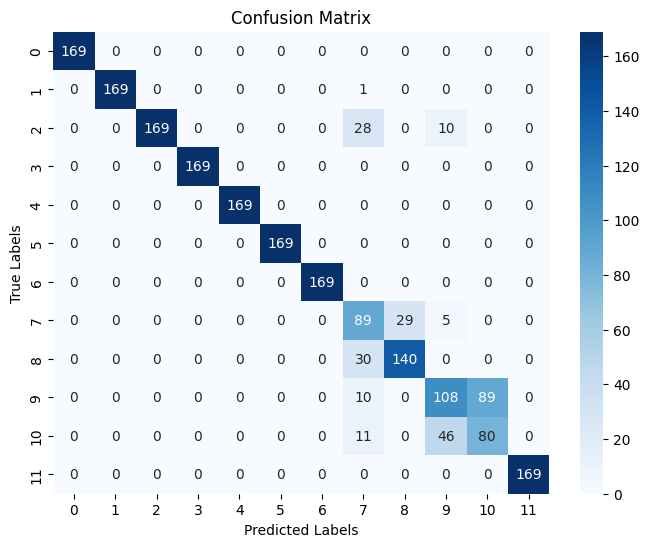

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(voting_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()